## **Area-average over complete surface**

Small script to calculate the area-averaged WSS for aneurysm case with different meshes for mesh convergence study.
The area-averaged WSS is defined as:

\begin{equation}
    WSS_A 
    =
    \frac{1}{A}
    \int_{S}{}
        \left\| \vec{WSS} (\vec{x},t) \right\| 
        \mathrm{d}S   
\end{equation}

where A is the area of the surface. Note that WSS_A will be a function of time. According to authors like Roach and Ferziger, in a Richardson extrapolation-like analysis, it is possible to use integral or derivatives of the priumitive variables to analyze mesh convergence. Ideally, one should analyze both primitive variables in specific locations and quadratures of these that are the variables that will be used in the study being carried-out. First, we will integrate the variables on the chosen surface and in the sequence, we must multiply the magWSS resultant field by the density $\rho = 1056 kg/m^3$, because the loaded 'wallShearComponent' in OpenFOAM is calculated per specific mass unity. 

## **OSI and RRT**

In this part of this notebook we will created a sequence of commands to calculate the *oscillatory shear index* (OSI) of a WSS field in an aneurysm surface, from CFD results and using ParaView's Temporal Statistics filter. The function also computes time-averaged data of the WSS, necessary in the OSI definition, and also the *relative residence time (RRT)*.

The OSI is defined as:

\begin{equation}
    OSI(\vec{x})
    =
    \frac{1}{2}
    \left(
        1 
        -
        \frac{
            \left \| 
            \displaystyle\int_0^{T}
            {
                \overrightarrow{WSS} (\vec{x},t)
                \mathrm{d}t
            }
            \right \|
        }{
            \displaystyle\int_0^{T}
            {
                \left \| \vec{WSS} (\vec{x},t) \right \|
                \mathrm{d}t
            }
        }
    \right)
\end{equation}

it measures how the WSS direction changes in time. The RRT is defined as:

\begin{equation}
    RRT(\vec{x})
    =
    \frac{1}{
            \frac{1}{T}
                \left \| 
                    \displaystyle\int_0^{T}
                    {
                        \vec{WSS} (\vec{x},t)
                        \mathrm{d}t
                    }
                \right \|
      }
     =
     \frac{1}{(1 - 2OSI)\overline{WSS}}
\end{equation}


## **Computing integrals over space (aneurysm surface) of time-averaged WSS**

The following code computes the integrals over the aneurysm surface of the time-averaged WSS, already calculated in a single surface by, for example, using the OSI function, above. Therefore, the code only clips the aneurysm neck in the same points as used above to compute the time-dependent WSS surface integrals. 

The procedure then will provide a representative value of WSS used for comparison with other publications. With the time-averaged defined as:

\begin{equation}
    \overline{WSS}(\vec{x})
    =
    \frac{1}{T}
    \int_0^{T}
    {
        \left \| \vec{WSS} (\vec{x},t) \right \|
        \mathrm{d}t
    }
\end{equation}

which is called "wallShearComponent_magnitude_average". This is, therefore, a single spatial field defined on the aneurysm surface. Two quantities are extracted from it: 

    - the aneurysm surface-averaged: 
\begin{equation}
    WSS_{av}
    =
    \frac{1}{A_a}
    \int_{S_a}{}
        \overline{WSS}(\vec{x})
    \mathrm{d}S_a   
\end{equation}

    - the maximum value of $\overline{WSS}(\vec{x})$:
\begin{equation}
    WSS_{max} 
    =
    \max_{\vec{x} \in S_a} \overline{WSS}(\vec{x})
\end{equation}

In [130]:
%%writefile aneurysms.py

import paraview.simple as pv
import numpy as np

def area_averaged_wss(case):
    """ Function that calculates the area-averaged WSS
        for a surface where the wall shear stress field
        is defined. The function takes its input an 
        OpenFOAM case reader with the surface and fields.
        It automatically selects the wallShearComponent field
        and the surface wall. It returns an array with time
        in one column and the result in the other. 
    """
    # Update arrays to be used:
    # - wallShearComponent
    

    case.CellArrays = ['wallShearComponent']

    # And select the surface where integration will be carried out
    case.MeshRegions = ['wall']

    # Get time-steps values
    timeSteps = np.array(case.TimestepValues)
    # Update time-step
    case.UpdatePipeline()

    # Integrate WSS on the wall
    computeWallArea = pv.IntegrateVariables()
    computeWallArea.Input = case
    computeWallArea.UpdatePipeline()
    # Get area of surface, in m2
    wallArea = computeWallArea.CellData.GetArray('Area').GetRange()[0]

    areaAveragedWSSList = []
    for timeStep in timeSteps:
        # Calculate WSS magnitude
        # Instantiate calculater filter
        calcMagWSS = pv.Calculator()
        calcMagWSS.Input = case
        calcMagWSS.ResultArrayName = 'magWSS'
        calcMagWSS.Function = '1056*mag(wallShearComponent)'
        calcMagWSS.AttributeType = 'Cell Data'
        calcMagWSS.UpdatePipeline(time=timeStep)

        # Integrate WSS on the wall
        integrateWSS = pv.IntegrateVariables()
        integrateWSS.Input = calcMagWSS
        integrateWSS.UpdatePipeline(time=timeStep)

        # Instantiate calculater filter
        areaAveragedWSS = pv.Calculator()
        areaAveragedWSS.Input = integrateWSS
        areaAveragedWSS.ResultArrayName = 'areaAveragedWSS'
        areaAveragedWSS.Function = 'magWSS/'+str(wallArea)
        areaAveragedWSS.AttributeType = 'Cell Data'
        areaAveragedWSS.UpdatePipeline(time=timeStep)
        areaAveragedWSSList.append([timeStep, 
                                    areaAveragedWSS.CellData.GetArray('areaAveragedWSS').GetRange()[0]])

    return np.asarray(areaAveragedWSSList)


def osi(ofCaseFile, 
        timeIndexRange, 
        outputFileName,
        timeStep=0.01,
        density=1056.0, # kg/m3
        wssFieldName='wallShearComponent', 
        patchName='wall'):
    """ 
        Function to calculate the oscillatory shear index and
        other time integrals variables of WSS over a time inter-
        val [Ti,Tf] indentified by time-step indices. The method
        (based o VTK), ignores the time-step size and 
        consider uniform time stepping (so, if the time-step is 
        large, the resulting fields may be very different if a va-
        riable time-step would be considered). The OSI field is 
        defined as:
        
            OSI = 0.5*( 1 - norm2(int WSS dt) / int norm2(WSS) dt)
            
        where "int" implies the integral over time between two
        instants t1 and t2 (usually for a cardiac cycle, therefore 
        [t1, t2] = [Ti, Tf]) and norm2 is the L2 norm of an Eucli-
        dean vector field; WSS is the wall shear stress defined on 
        the input surface. Since this function use OpenFOAM data, 
        please specify the density considered.
        
        Input args:
        - OpenFOAM case file (str): name of OpenFOAM .foam case;
        - wssFieldName (str, optional): string containing the name 
            of the wall shear stress field (default="wallShearComp-
            onent");
        - patchName (str, optional): patch name where to calculate 
            the OSI (default="wall");
        - timeIndexRange (list): list of initial and final time-
            steps indices limits of the integral [Ti, Tf];
        - outputFileName (str): file name for the output file with 
            osi field (must be a .vtp file).
        - blood density (float, optional): default 1056.0 kg/m3
    """
    case = pv.OpenFOAMReader(FileName=ofCaseFile)

    # First we define only the field that are going to be used: the WSS on the aneurysm wall
    case.CellArrays = [wssFieldName]
    case.MeshRegions = [patchName]
    case.Createcelltopointfiltereddata = 0

    # Multiplying WSS per density
    densityTimesWSS = pv.Calculator()
    densityTimesWSS.Input = case
    densityTimesWSS.AttributeType = 'Cell Data'
    densityTimesWSS.ResultArrayName = "WSS"
    densityTimesWSS.Function = str(density)+"*"+wssFieldName
    densityTimesWSS.UpdatePipeline()

    # Calculating the magnitude of the wss vector
    calcMagWSS = pv.Calculator()
    calcMagWSS.Input = densityTimesWSS
    calcMagWSS.AttributeType = 'Cell Data'
    calcMagWSS.ResultArrayName = densityTimesWSS.ResultArrayName+"_magnitude"

    ## Get WSS field name
    wss = densityTimesWSS.ResultArrayName
    calcMagWSS.Function = "mag("+wss+")"
    calcMagWSS.UpdatePipeline()

    # Extract desired time range
    timeInterval = pv.ExtractTimeSteps()
    timeInterval.Input = calcMagWSS
    timeInterval.SelectionMode = "Select Time Range"
    timeInterval.TimeStepRange = timeIndexRange #[99, 199] # range in index
    timeInterval.UpdatePipeline()

    # Period given by time-steps
    period = (timeInterval.TimeStepRange[1] - timeInterval.TimeStepRange[0])*timeStep

    # Now compute the temporal statistics
    # filter computes the average values of all fields
    calcAvgWSS = pv.TemporalStatistics()

    calcAvgWSS.Input = timeInterval
    calcAvgWSS.ComputeAverage = 1
    calcAvgWSS.ComputeMinimum = 0
    calcAvgWSS.ComputeMaximum = 0
    calcAvgWSS.ComputeStandardDeviation = 0
    calcAvgWSS.UpdatePipeline()

    # Calculates OSI
    calcOSI = pv.Calculator()
    calcOSI.Input = calcAvgWSS
    calcOSI.ResultArrayName = 'OSI'
    calcOSI.AttributeType = 'Cell Data'

    # Getting fields:
    # - Get the average of the vector WSS field
    avgVecWSS = calcAvgWSS.CellData.GetArray(wss+"_average").GetName()
    # - Get the average of the magnitude of the WSS field 
    avgMagWSS = calcAvgWSS.CellData.GetArray(calcMagWSS.ResultArrayName+"_average").GetName()

    calcOSI.Function = "0.5*( 1 - ( mag( "+avgVecWSS+" ) )/"+avgMagWSS+" )"
    calcOSI.UpdatePipeline()

    # Compute Relative Residance Time
    calcRRT = pv.Calculator()
    calcRRT.Input = calcOSI
    calcRRT.ResultArrayName = 'RRT'
    calcRRT.AttributeType = 'Cell Data'
    calcRRT.Function = str(period)+"/mag("+avgVecWSS+")"
    calcRRT.UpdatePipeline()

    # Final processing of surface: merge blocks
    # and get surface for triangulation
    mergeBlocks = pv.MergeBlocks()
    mergeBlocks.Input = calcRRT
    mergeBlocks.UpdatePipeline()

    extractSurface = pv.ExtractSurface()
    extractSurface.Input = mergeBlocks
    extractSurface.UpdatePipeline()

    triangulate = pv.Triangulate()
    triangulate.Input = extractSurface
    triangulate.UpdatePipeline()

    pv.SaveData(outputFileName,triangulate)

    
def wss_statistics(timeAveragedSurface, aneurysmNeckArrayName, neckIsoValue=0.5):
    """
        Computes surface-averaged and maximum value 
        of time-averaged WSS for an aneurysm surface.
        Input is a PolyData surface with the averaged
        fields and the aneurysm neck contour field. 
        Return list with aneurysm area, WSSav and 
        WSSmax.
    """
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input = timeAveragedSurface
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars  = [timeAveragedSurface.PointData.GetArray(aneurysmNeckArrayName).Name]
    clipAneurysmNeck.Invert   = 1   # gets smaller portion
    clipAneurysmNeck.Value    = neckIsoValue  # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline()

    # Finaly we integrate over Sa 
    integrateOverAneurysm = pv.IntegrateVariables()
    integrateOverAneurysm.Input = clipAneurysmNeck
    integrateOverAneurysm.UpdatePipeline()

    aneurysmArea = integrateOverAneurysm.CellData.GetArray("Area").GetRange()[0] # aneurysm area

    WSSav = integrateOverAneurysm.CellData.GetArray("WSS_magnitude_average").GetRange()[0]/aneurysmArea # averaged
    WSSmax = clipAneurysmNeck.CellData.GetArray("WSS_magnitude_average").GetRange()[1] # maximum value

    return [aneurysmArea, WSSav, WSSmax]

Overwriting aneurysms.py


<hr>

<hr>

In [ ]:
pathToFoamCase = "/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Newtonian/case1/mesh1500k/" 
foamFileName = "mesh1500k.foam"

In [ ]:
data = pv.OpenFOAMReader(FileName=pathToFoamCase+foamFileName)

In [ ]:
data.CellData.GetNumberOfArrays()

In [ ]:
meshIntermediateWSS = area_averaged_wss(data)
meshIntermediateWSS

In [81]:
import matplotlib.pyplot as plt
import seaborn as sb

In [82]:
plt.style.use('classic')

In [ ]:
#%matplotlib widget
fig = plt.figure()

plt.plot(meshIntermediateWSS[:,0], meshIntermediateWSS[:,1], 'b')

plt.xlabel('Time')
plt.ylabel('Area-averaged WSS (Pa)')

plt.grid()
plt.show()

<hr>

In [ ]:
# pathToFoamCase = "/home/iago/foam/iago-4.0/run/aneurysms/unruptured/fluidFlow/Newtonian/case11/mesh600k/" 
# foamFileName = "mesh600k.foam"

In [ ]:
# osi(pathToFoamCase+foamFileName,[99, 199],pathToFoamCase+"OSI_new.vtp")

In [63]:
# Calculating time averaged data of a collection of OpenFOAM data

rootPath = "/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/"
models   = ["Newtonian", "Casson", "CarreauYasuda"]
rupturedCases   = ["case1/mesh1500k", "case2/mesh1500k", "case19/mesh1500k"]
unrupturedCases = ["case11/mesh1500k", "case13/mesh1500k", "case17/mesh1100k"]

rupturedCasesFiles   = [ rootPath+"ruptured/fluidFlow/"+model+"/"+case for model in models for case in rupturedCases ] 
unrupturedCasesFiles = [ rootPath+"unruptured/fluidFlow/"+model+"/"+case for model in models for case in unrupturedCases ] 

casePaths = rupturedCasesFiles+unrupturedCasesFiles

# Update one of the folders
casePaths

['/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Newtonian/case1/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Newtonian/case2/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Newtonian/case19/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Casson/case1/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Casson/case2/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Casson/case19/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/CarreauYasuda/case1/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/CarreauYasuda/case2/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/CarreauYasuda/case19/mesh1500k',
 '/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/unruptured/fluidFlow/Newtonian/case11/mesh1500k',
 '/home/iag

In [66]:
# Where to store the processes data 
rootPath = "/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/"
rupturedCases2   = ["case1", "case2", "case19"]
unrupturedCases2 = ["case11", "case13", "case17"]
rupturedWrite    = [ rootPath+"ruptured/fluidFlow/"+model+"/"+case+"/"+case+"_timeAveragedWSSandOSI_"+model+".vtp" for model in models for case in rupturedCases2 ] 
unrupturedWrite  = [ rootPath+"unruptured/fluidFlow/"+model+"/"+case+"/"+case+"_timeAveragedWSSandOSI_"+model+".vtp" for model in models for case in unrupturedCases2 ] 
saveFiles = rupturedWrite+unrupturedWrite
saveFiles

['/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/Newtonian/case1/case1_timeAveragedWSSandOSI_Newtonian.vtp',
 '/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/Newtonian/case2/case2_timeAveragedWSSandOSI_Newtonian.vtp',
 '/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/Newtonian/case19/case19_timeAveragedWSSandOSI_Newtonian.vtp',
 '/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/Casson/case1/case1_timeAveragedWSSandOSI_Casson.vtp',
 '/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/Casson/case2/case2_timeAveragedWSSandOSI_Casson.vtp',
 '/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/Casson/case19/case19_timeAveragedWSSandOSI_Casson.vtp',
 '/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/ruptured/fluidFlow/CarreauYasuda/case1/case1_timeAveragedWSSandOSI_Carr

In [50]:
# for inputFile,outputFile in zip(caseFiles,saveFiles):
#     print("Processing case",inputFile)
#     osi(inputFile, [99,199], outputFile)
#     print("Saving file",outputFile)

<hr>

From the time averaged files created above, area-averaging them to get WSS statistics

In [ ]:
# We can work directly from the OSI surface with ContourScalars
# The time averaged values are defined per unit blood density

timeAveragedSurface = pv.XMLPolyDataReader(FileName="/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/test/case11_timeAveragedWSSandOSI_Newtonian.vtp")
timeAveragedSurface.CellArrayStatus, timeAveragedSurface.PointArrayStatus

In [67]:
import os

In [ ]:
fileList = glob.glob("/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/test/*.vtp")
fileList

In [73]:
rupturedCases = ["case1", "case2", "case4ruptured", "case19"]
unrupturedCases = ["case4unruptured", "case11", "case13", "case17"]
cases = rupturedCases+unrupturedCases

statistics = { key: {} for key in cases}
statistics

{'case1': {},
 'case2': {},
 'case4ruptured': {},
 'case19': {},
 'case4unruptured': {},
 'case11': {},
 'case13': {},
 'case17': {}}

In [74]:
# Calculate statistics for all files above
for file in saveFiles:
    # Load surface
    timeAveragedSurface = pv.XMLPolyDataReader(FileName=file)
    # Get file case identifier
    identifier = os.path.basename(file).strip(".vtp").split("_")
    # Compute array statistics
    stat = wss_statistics(timeAveragedSurface, "AneurysmNeckContour")
    
    # Save data in dictionary
    statistics[identifier[0]][identifier[2]] = {"Area" : stat[0],
                                                "WSSav": stat[1],
                                                "WSSmax": stat[2]}

In [75]:
# Computing WSSav and WSSmax for case 4: two aneurysms, one ruptured and unruptured
osiData = ["/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/test/case4_timeAveragedWSSandOSI_CarreauYasuda.vtp",
           "/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/test/case4_timeAveragedWSSandOSI_Casson.vtp",
           "/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/test/case4_timeAveragedWSSandOSI_Newtonian.vtp"]
# Calculate statistics for all files above
for aneurysmState in ("ruptured","unruptured"):    
    for file in osiData:
        # Load surface
        timeAveragedSurface = pv.XMLPolyDataReader(FileName=file)
        # Get file case identifier
        identifier = os.path.basename(file).strip(".vtp").split("_")
        # Compute array statistics
        stat = wss_statistics(timeAveragedSurface, aneurysmState+"AneurysmNeckContour")

        # Save data in dictionary
        statistics[identifier[0]+aneurysmState][identifier[2]] = {"Area" : stat[0],
                                                                  "WSSav": stat[1],
                                                                  "WSSmax": stat[2]}

In [76]:
def prettyDict(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [77]:
# Data for all aneurysms cases and models tested
prettyDict(statistics)

case1
	Newtonian
		Area
			0.00010151451255767403
		WSSav
			5.118493900544775
		WSSmax
			30.67953155275846
	Casson
		Area
			0.00010151451255767403
		WSSav
			5.274962115038898
		WSSmax
			34.954458961727454
	CarreauYasuda
		Area
			0.00010151451255767403
		WSSav
			5.073598001032694
		WSSmax
			32.113891955736115
case2
	Newtonian
		Area
			0.0001831859638745846
		WSSav
			3.3436038120647
		WSSmax
			42.611818788368296
	Casson
		Area
			0.0001831859638745846
		WSSav
			3.3946184593265145
		WSSmax
			46.43173299297158
	CarreauYasuda
		Area
			0.0001831859638745846
		WSSav
			3.408467338085822
		WSSmax
			42.02878767239075
case4ruptured
	CarreauYasuda
		Area
			0.00011551529168752638
		WSSav
			8.309586651550902
		WSSmax
			40.062276665346815
	Casson
		Area
			0.00011553205422033547
		WSSav
			8.726983900036284
		WSSmax
			42.59225919710281
	Newtonian
		Area
			0.00011553205422033547
		WSSav
			8.536038552786708
		WSSmax
			40.34154811871242
case19
	Newtonian
		Area
			0.00016341621986

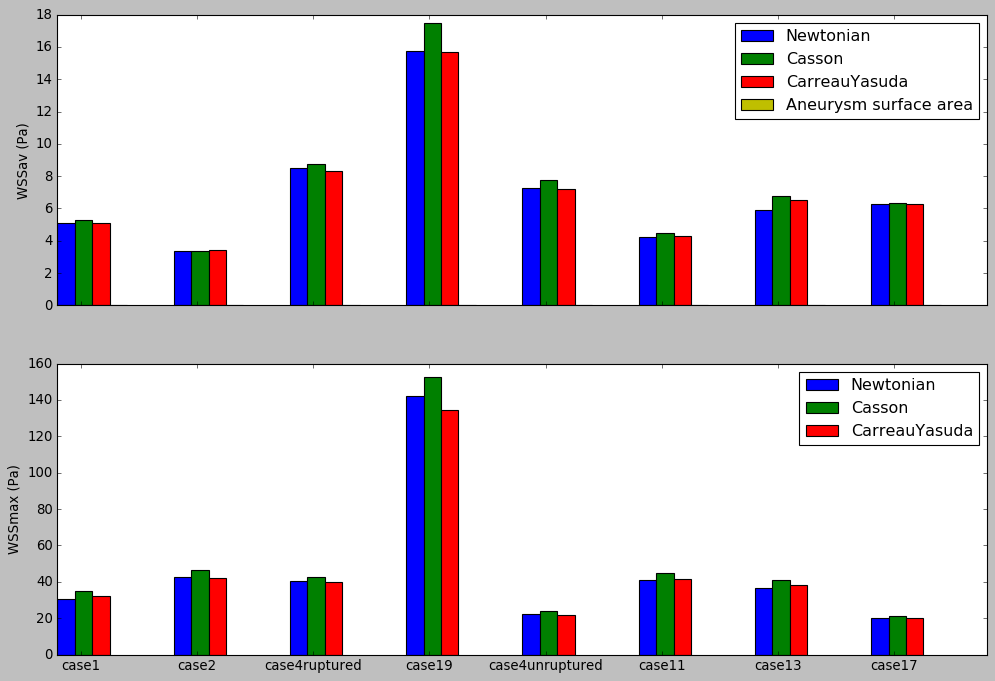

In [129]:
analyzedCases = rupturedCases+unrupturedCases 
bwidth=0.15

# Instantiate subplots
fig,(ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))

X = np.arange(8)

ax1.bar(X + 0.00, [statistics[case]["Newtonian"]["WSSav"] for case in analyzedCases], color = 'b', width=bwidth, label="Newtonian")
ax1.bar(X + 0.15, [statistics[case]["Casson"]["WSSav"] for case in analyzedCases], color = 'g', width=bwidth, label="Casson")
ax1.bar(X + 0.30, [statistics[case]["CarreauYasuda"]["WSSav"] for case in analyzedCases], color = 'r', width=bwidth, label="CarreauYasuda")

ax1.set_ylabel('WSSav (Pa)')
ax1.legend()

ax2.bar(X + 0.00, [statistics[case]["Newtonian"]["WSSmax"] for case in analyzedCases], color = 'b', width=bwidth, label="Newtonian")
ax2.bar(X + 0.15, [statistics[case]["Casson"]["WSSmax"] for case in analyzedCases], color = 'g', width=bwidth, label="Casson")
ax2.bar(X + 0.30, [statistics[case]["CarreauYasuda"]["WSSmax"] for case in analyzedCases], color = 'r', width=bwidth, label="CarreauYasuda")

ax2.set_ylabel('WSSmax (Pa)')
ax2.legend()
plt.xticks(X+0.20, analyzedCases)

plt.show()

<hr>

<hr>

# Post-process aneurysm surface integrals over time

The procedure below calculates the integral over the aneurysm surface $S_a$ of the WSS magnitude, which is a time-dependent integral:

\begin{equation}
    \left \langle \vec{WSS} \right \rangle (t)
    =
    \frac{1}{A_a}
    \int_{S_a}{}
        \left \| \vec{WSS} \right \|
    \mathrm{d}S_a   
\end{equation}

which is a measure of the total traction due to the tangential component of viscous traction on the aneurysm surface $S_a$. 

The procedure loads an OpenFOAM case of the aneurysm simulation and another surface must be loaded where is stored the array to clip the aneurysm neck: this can be performed in VMTK on a surface where the time averaged field were computed (time-average of WSS magnitude, magnitude of time-averaged WSS vector and OSI). 

In [5]:
pathToFoamCase = "/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/unruptured/fluidFlow/Newtonian/case11/mesh600k/" 
foamFileName = "mesh600k.foam"
ofCaseFile=pathToFoamCase+foamFileName

In [11]:
# Load surface with clip array and OSI data
# The surface with clip array must be constructed using VMTK,
# based on the surface with already 

aneurysmClipSurface = pv.XMLPolyDataReader(FileName="/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/test/case11_timeAveragedWSSandOSI_Newtonian.vtp")
aneurysmClipSurface.CellArrayStatus, clipArraySurface.PointArrayStatus

(['OSI', 'RRT', 'WSS_average', 'WSS_magnitude_average', 'wallShearComponent_average'],
 ['AneurysmNeckContour'])

In [24]:
aneurysmNeckArrayName = 'AneurysmNeckContour'

In [ ]:
def area_averaged_wss_aneurysm(ofCaseFile,aneurysmClipSurface,aneurysmNeckArrayName,density=1056.0):
    """
        Function to compute surface integrals of 
        WSS over an aneurysm surface. It takes the 
        OpenFOAM case file and an extra surface where 
        it is stored a field with the aneurysm neck 
        line loaded as a ParaView PolyData surface.
    """
    

In [37]:
# Read OpenFOAM data
ofData = pv.OpenFOAMReader(FileName=ofCaseFile)

# Update arrays to be used:
# - wallShearComponent
# - pressure
ofData.CellArrays = ['wallShearComponent']
ofData.SkipZeroTime = 1
# And select the surface where integration will be carried out
ofData.MeshRegions = ['wall']

# Get time-steps values
timeSteps = np.array(ofData.TimestepValues)

# Update time-step
ofData.UpdatePipeline()

# Merge blocks of input case
# mergeBlocks = pv.MergeBlocks()
# mergeBlocks.Input = ofData
# mergeBlocks.MergePoints = 1
# mergeBlocks.UpdatePipeline()
# Resample data: copy array of Input data (surface with time-averaged data) 
# to Source data (the OpenFOAM simulated case)     

In [41]:
areaAveragedWSSList = []

# # Iterate over time-steps to compute time dependent variables
# # only on the aneurysm surface: mag of WSS over time 
for timeStep in timeSteps[0:25]: # get last cycle only
#         # Resample data: copy array of Input data (surface with time-averaged data) 
#         # to Source data (the OpenFOAM simulated case)
    ofData.UpdatePipeline(time=timeStep)
    
    mergeBlocks = pv.MergeBlocks()
    mergeBlocks.Input = ofData
    mergeBlocks.MergePoints = 1
    mergeBlocks.UpdatePipeline(time=timeStep)
    
    resampleDataset = pv.ResampleWithDataset()
    resampleDataset.Input = aneurysmClipSurface
    resampleDataset.Source = mergeBlocks
    resampleDataset.CategoricalData = 0
    resampleDataset.ComputeTolerance = 1
    resampleDataset.PassCellArrays = 1
    resampleDataset.PassPointArrays = 1
    resampleDataset.UpdatePipeline(time=timeStep)

    # Clipping aneurysm surface on its neck 
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input = resampleDataset
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars = [aneurysmNeckArrayName]
    clipAneurysmNeck.Invert = 1   # gets smaller portion
    clipAneurysmNeck.Value = 0.5  # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline(time=timeStep)

    density = 1056.
    # Compute magnitude of WSS in each cell of the aneurysm surface
    magWSS = pv.Calculator()
    magWSS.Input = clipAneurysmNeck
    magWSS.ResultArrayName = 'magWSS'
    magWSS.Function = str(density)+'*mag('+clipAneurysmNeck.CellData.GetArray('wallShearComponent').Name+')'
    magWSS.AttributeType = 'Cell Data'
    magWSS.UpdatePipeline(time=timeStep)

    # Integrate WSS on the wall
    integrateWSS = pv.IntegrateVariables()
    integrateWSS.Input = magWSS
    integrateWSS.UpdatePipeline(time=timeStep)

    # Get area of surface, in m2
    aneurysmArea = integrateWSS.CellData.GetArray("Area").GetRange()[0]

    # Instantiate calculater filter
    areaAveragedWSS = pv.Calculator()
    areaAveragedWSS.Input = integrateWSS
    areaAveragedWSS.ResultArrayName = 'areaAveragedWSS'
    areaAveragedWSS.Function = integrateWSS.CellData.GetArray('magWSS').Name+'/'+str(aneurysmArea)
    areaAveragedWSS.AttributeType = 'Cell Data'
    areaAveragedWSS.UpdatePipeline(time=timeStep)

    areaAveragedWSSList.append([timeStep, areaAveragedWSS.CellData.GetArray('areaAveragedWSS').GetRange()[0]])
# del resampleDataset, clipAneurysmNeck, integrateWSS, magWSS, areaAveragedWSS

# return np.asarray(areaAveragedWSSList)

In [43]:
del resampleDataset,areaAveragedWSS,ofData

In [42]:
areaAveragedWSSList

[[0.01, 3.961980378145478],
 [0.02, 4.36926237907882],
 [0.03, 4.715919649737067],
 [0.04, 5.201493650760484],
 [0.05, 5.694370589487438],
 [0.06, 6.212682693783065],
 [0.07, 6.996393009615028],
 [0.08, 8.476859231884907],
 [0.09, 9.695819243790678],
 [0.1, 11.034190764687338],
 [0.11, 12.030919549429388],
 [0.12, 12.543582251253058],
 [0.13, 12.85739474268449],
 [0.14, 12.56985872207902],
 [0.15, 12.181819138097302],
 [0.16, 11.664796983374027],
 [0.17, 11.186948311440148],
 [0.18, 10.617673202707584],
 [0.19, 9.986168154520481],
 [0.2, 9.346239460905316],
 [0.21, 8.830286939614219],
 [0.22, 8.589851018911126],
 [0.23, 8.44275871892645],
 [0.24, 8.403910572232595],
 [0.25, 8.538877461963823]]

Now, let's post process the OpenFOAM data to get the aneurysm-surface averaged WSS over time.

In [ ]:
nCases = 6
nModels = 3
WSSt = np.zeros(shape=(nCases,99,3))

In [ ]:
# Calculate statistics for all files above
for file,output in zip(caseFiles[0:1],saveFiles[0:1]):
    print(file,output)
    # Load surface
    timeAveragedSurface = pv.XMLPolyDataReader(FileName=output)
    # Get file case identifier
    identifier = os.path.basename(output).strip(".vtp").split("_")
    
    # Compute WSS in time
    wssTime = area_averaged_wss_aneurysm(file, timeAveragedSurface, "AneurysmNeckContour")
    
    # Save data in dictionary
    WSSt[0,:,0] = wssTime

In [ ]:
WSSt

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('classic')

In [ ]:
#%matplotlib widget

fig = plt.figure()

plt.plot(array[:,0], array[:,1], 'b')

plt.xlabel('Time')
plt.ylabel('Area-averaged WSS (Pa)')

plt.grid()
plt.show()